In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from pandas_datareader import data as pdr
import math

# Keras related imports for building neural network models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import plot_model

# Set plotting styles for visualizations
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")

# Ensure that matplotlib plots inline in Jupyter Notebooks
%matplotlib inline

# Set up Yahoo Finance API using yfinance
yf.pdr_override()
import yfinance as yf

# Install and import pandas_ta for technical analysis indicators (optional)
!pip install pandas_ta
import pandas_ta as ta

# Function to save plots with a specified image name and resolution
def save_plot(fig, image_name):
    """
    Save a matplotlib figure with a specified name and resolution.

    Parameters:
    fig (matplotlib.figure.Figure): The figure to save.
    image_name (str): The name of the image file.

    Returns:
    None
    """
    fig.savefig(f"{image_name}.png", dpi=300)


##**Data Loading**

This code will fetch 15 years of NVIDIA's stock data from Yahoo Finance and display the first few rows of the data. This long-term dataset can provide a comprehensive view for analyzing trends, patterns, and potential forecasting models.

In [2]:
# Fetch NVIDIA stock data from Yahoo Finance
ticker = 'NVDA'  # NVIDIA's stock ticker symbol
end_date = datetime.now().strftime('%Y-%m-%d')  # Current date in 'YYYY-MM-DD' format
start_date = (datetime.now() - pd.DateOffset(years=15)).strftime('%Y-%m-%d')  # Date 15 years ago

# Download stock data from start_date to end_date
data = yf.download(ticker, start=start_date, end=end_date)

# Display the first few rows of the fetched data
print(data.head())

[*********************100%%**********************]  1 of 1 completed
              Open    High     Low  Close  Adj Close    Volume
Date                                                          
2008-12-15  2.1625  2.1750  2.0125  2.080   1.908077  47699600
2008-12-16  2.1000  2.2250  2.0800  2.220   2.036506  52194000
2008-12-17  2.1800  2.3625  2.1500  2.330   2.137414  67418000
2008-12-18  2.3150  2.3225  2.0875  2.115   1.940185  55080800
2008-12-19  2.1425  2.2250  2.1225  2.130   1.953945  59312000


##**Descriptive Statistics about the Data**
`.describe()` generates descriptive statistics. Descriptive statistics include those that summarize the central tendency, dispersion, and shape of a dataset’s distribution, excluding `NaN` values.

`.info()` method prints information about a DataFrame including the index `dtype` and columns, non-null values, and memory usage.

In [3]:
# Display information about the NVIDIA stock data
print(data.info())

# Generate a statistical summary for the NVIDIA stock data
print(data.describe())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3774 entries, 2008-12-15 to 2023-12-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3774 non-null   float64
 1   High       3774 non-null   float64
 2   Low        3774 non-null   float64
 3   Close      3774 non-null   float64
 4   Adj Close  3774 non-null   float64
 5   Volume     3774 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 206.4 KB
None
              Open         High          Low        Close    Adj Close  \
count  3774.000000  3774.000000  3774.000000  3774.000000  3774.000000   
mean     66.692517    67.904171    65.435176    66.725187    66.448452   
std     103.973186   105.819991   101.993043   103.979414   104.009116   
min       1.802500     1.867500     1.770000     1.802500     1.653515   
25%       3.833750     3.880000     3.783125     3.832500     3.552993   
50%      11.640000    11.820000    11.542500    11.6800

##**Exploratory Data Analysis**

###Closing Price
The closing price is the last price at which the stock is traded during the regular trading day. A stock’s closing price is the standard benchmark used by investors to track its performance over time.

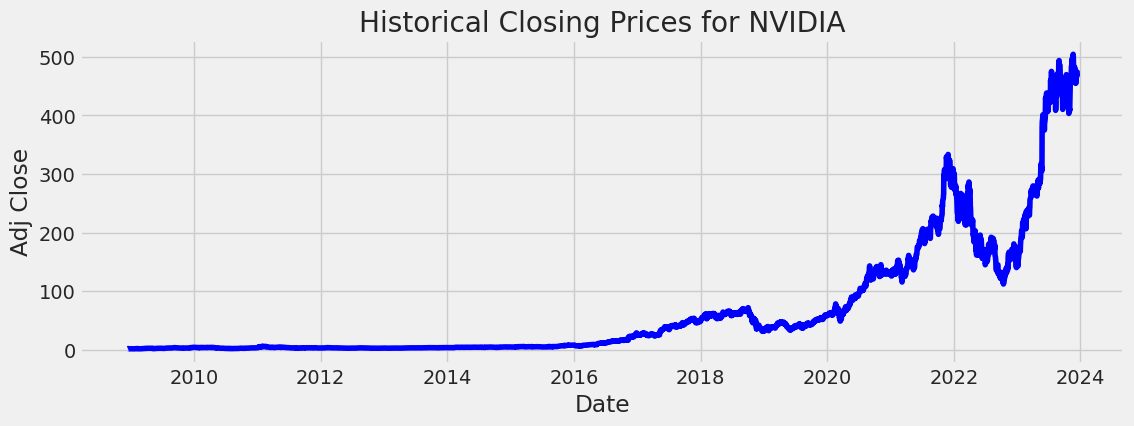

In [4]:
# Copying the data to a new DataFrame for manipulation
company = data.copy()  # Create a copy of the NVIDIA stock data

# Setting a title for the plot
company_title = "NVIDIA"

# Creating a figure for plotting historical closing prices
fig, ax = plt.subplots(figsize=(12, 4))  # Set the size of the plot

# Plotting the Adjusted Close Prices
ax.plot(company.index, company["Adj Close"], color='blue', label='Adj Close')  # Plotting the 'Adj Close' prices

# Adding title and labels
ax.set_title(f"Historical Closing Prices for {company_title}")  # Title of the plot
ax.set_xlabel('Date')  # Label for X-axis
ax.set_ylabel('Adj Close')  # Label for Y-axis

# Displaying the plot
plt.show()

# Saving the plot using the save_plot function
save_plot(fig, 'NVIDIA_Stock_Price')  # Save the figure as 'NVIDIA_Stock_Price.png' with 300 DPI

The graph shows a long-term upward trend in NVIDIA's stock price with notable volatility and several significant fluctuations.

From the start of the graph, which seems to begin around 2010, up until around 2016, NVIDIA's stock price remained relatively modest without dramatic changes, suggesting a period of steady business without market-shaking events. This could be attributed to consistent business performance and a strong foundation in the graphics processing unit (GPU) market, where NVIDIA has been a leading player.

Starting in 2016, there is a sharp increase in stock price, indicating a period of rapid growth. This could correlate with several factors such as NVIDIA's successful expansion into new markets like AI, deep learning, and autonomous vehicles, which likely fueled investor optimism.

The peak seen around 2018 followed by a sharp decline might be associated with market corrections or specific challenges such as supply chain issues, competitive pressures, or shifts in the semiconductor industry that NVIDIA operates within.

The recovery and subsequent rise in price after the decline could be a result of overcoming previous challenges, launching new products, or capitalizing on emerging trends like cloud gaming, data centers, and renewed interest in cryptocurrencies, which often drive demand for GPUs.

The very sharp rise in stock price leading into 2022 could be due to multiple factors such as the increased demand for computing power in various technology sectors where NVIDIA's products are key, including gaming, professional visualization, data centers, and automotive electronics. This period also coincides with the global semiconductor shortage which, while presenting challenges, may have led to increased prices and revenue for available products.

The graph ends with what appears to be a plateau or a slight dip, which might indicate market saturation, investor skepticism about continued growth at the same rate, or broader economic factors affecting the tech industry.

Throughout this period, NVIDIA likely faced challenges including intense competition, rapid technological changes, market saturation in certain segments, regulatory challenges, and the impact of global events such as trade disputes and the COVID-19 pandemic. Each of these factors can lead to significant volatility in stock prices as investor sentiment shifts with the perception of the company's future performance.

###Volume of Sales
Volume is the amount of an asset or security that changes hands over some period of time, often over the course of a day. For instance, the stock trading volume would refer to the number of shares of security traded between its daily open and close. Trading volume, and changes to volume over the course of time, are important inputs for technical traders.

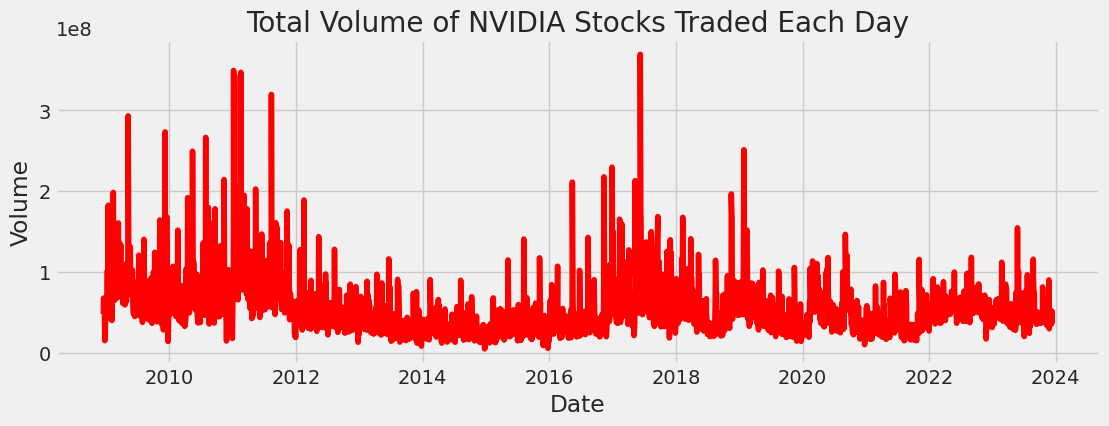

In [5]:
# Creating a figure for plotting the total volume of stocks traded
fig, ax = plt.subplots(figsize=(12, 4))  # Set the size of the plot

# Plotting the Volume of stocks traded
ax.plot(company.index, company["Volume"], color='red', label='Volume')  # Plotting the 'Volume'

# Adding title and labels
ax.set_title(f"Total Volume of {company_title} Stocks Traded Each Day")  # Title of the plot
ax.set_xlabel('Date')  # Label for X-axis
ax.set_ylabel('Volume')  # Label for Y-axis

# Displaying the plot
plt.show()

# Saving the plot using the save_plot function
save_plot(fig, 'NVIDIA_Stock_Volume')  # Save the figure as 'NVIDIA_Stock_Price.png' with 300 DPI

The graph illustrates the number of shares traded on a daily basis and shows significant variability over the observed time period.

From the beginning of the graph around 2010, there are spikes in volume traded, which often correspond to significant corporate events, earnings reports, product launches, or broader market movements. Periods of higher trading volume may indicate increased investor interest or reactions to market news.

Around the years 2011 and 2012, we see some of the first notable spikes in volume, which may be associated with specific events such as product announcements or market responses to financial results.

The consistent trading volume from 2013 to 2015 suggests a period of stability where significant market-moving events were less frequent or impactful.

The increased volume seen in 2016 and 2017 coincides with the sharp increase in NVIDIA's stock price during the same period, which could be due to factors such as entering new markets like AI and autonomous driving, which likely increased investor interest and trading activity.

In 2018, there's a noticeable spike, possibly relating to the quick rise and fall in stock price that could be attributed to market corrections or reactions to specific news or industry trends.

The spikes in volume in the years 2020 and 2021 could be linked to the global events such as the COVID-19 pandemic and the semiconductor shortage, both of which had significant impacts on tech stocks and market volatility.

It's important to note that high volume days can be associated with both positive and negative news. For instance, a spike could result from a sell-off due to poor earnings or market downturns, or from accumulation due to optimistic future earnings guidance or successful product launches.

Overall, this graph showcases the dynamic and often reactive nature of the stock market, where trading volumes can provide insights into investor sentiment and market activity in response to news, events, and broader economic conditions. To understand the specific causes behind each peak in volume, one would typically review news articles, press releases, and financial reports that correspond to the dates of these spikes.

###Moving Averages
The moving average (MA) is a simple technical analysis tool that smooths out price data by creating a constantly updated average price. The average is taken over a specific period of time, like 10 days, 20 minutes, 30 weeks, or any time period the trader chooses.

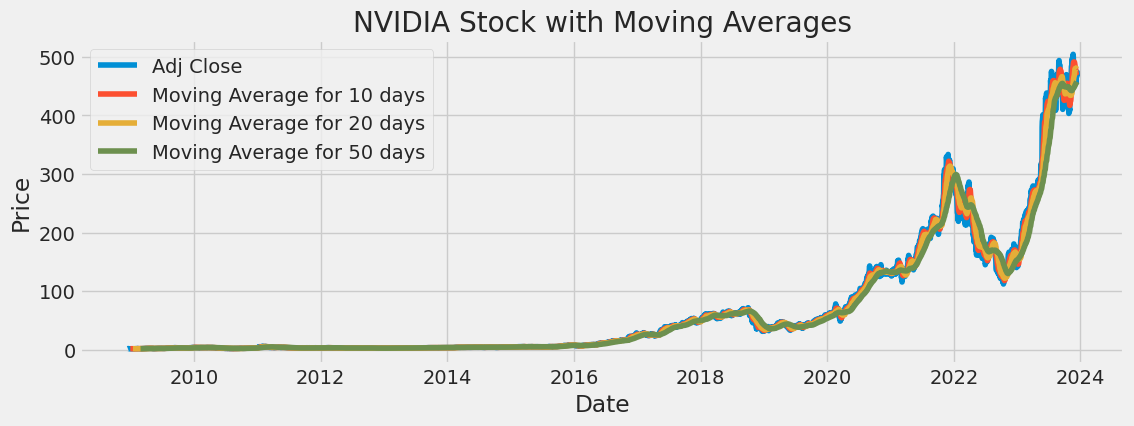

In [6]:
# Calculate moving averages
moving_average_days = [10, 20, 50]  # Define the moving average periods
for moving_average in moving_average_days:
    column_name = f'Moving Average for {moving_average} days'
    # Calculate the moving average and store in a new column
    company[column_name] = company["Adj Close"].rolling(moving_average).mean()

# Creating a figure for plotting moving averages
fig, ax = plt.subplots(figsize=(12, 4))  # Set the size of the plot

# Plotting the Adjusted Close Prices
ax.plot(company.index, company["Adj Close"], label='Adj Close')  # Plotting the 'Adj Close' prices

# Plotting each moving average
for moving_average in moving_average_days:
    column_name = f'Moving Average for {moving_average} days'
    ax.plot(company.index, company[column_name], label=column_name)  # Plotting each moving average

# Adding title, labels, and legend
ax.set_title(f"{company_title} Stock with Moving Averages")  # Title of the plot
ax.set_xlabel('Date')  # Label for X-axis
ax.set_ylabel('Price')  # Label for Y-axis
ax.legend()  # Display legend

# Displaying the plot
plt.show()

# Saving the plot using the save_plot function
save_plot(fig, 'NVIDIA_Stock_Moving_Averages')  # Save the figure as 'NVIDIA_Stock_Moving_Averages.png' with 300 DPI


###Daily Returns of the Stock
Now that we've done some baseline analysis, let's go ahead and dive a little deeper. We're now going to analyze the risk of the stock. In order to do so we'll need to take a closer look at the daily changes of the stock, and not just its absolute value. Let's go ahead and use pandas to retrieve teh daily returns for the Apple stock.

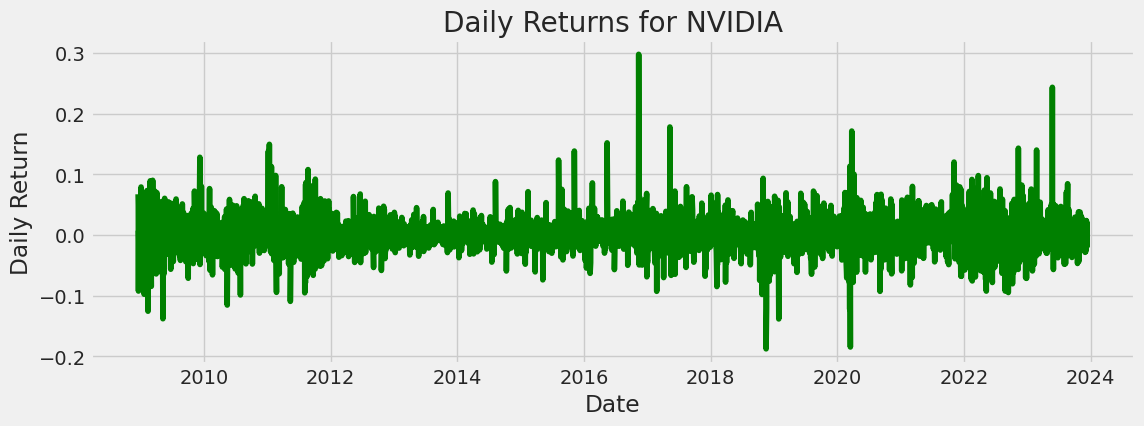

In [7]:
# Calculate daily returns of the stock
company["Daily Return"] = company["Adj Close"].pct_change()  # Calculate percentage change for daily return

# Creating a figure for plotting daily returns
fig, ax = plt.subplots(figsize=(12, 4))  # Set the size of the plot

# Plotting the daily returns
ax.plot(company.index, company["Daily Return"], color='green', label='Daily Return')  # Plotting the 'Daily Return'

# Adding title and labels
ax.set_title(f"Daily Returns for {company_title}")  # Title of the plot
ax.set_xlabel('Date')  # Label for X-axis
ax.set_ylabel('Daily Return')  # Label for Y-axis

# Displaying the plot
plt.show()

# Saving the plot using the save_plot function
save_plot(fig, 'NVIDIA_Stock_Daily_Returns')  # Save the figure as 'NVIDIA_Stock_Daily_Returns.png' with 300 DPI


let's get an overall look at the average daily return using a histogram.

<ipython-input-8-2b26c1e4c499>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(company["Daily Return"].dropna(), color="purple", label='Daily Return Distribution', ax=ax)  # Plotting the distribution


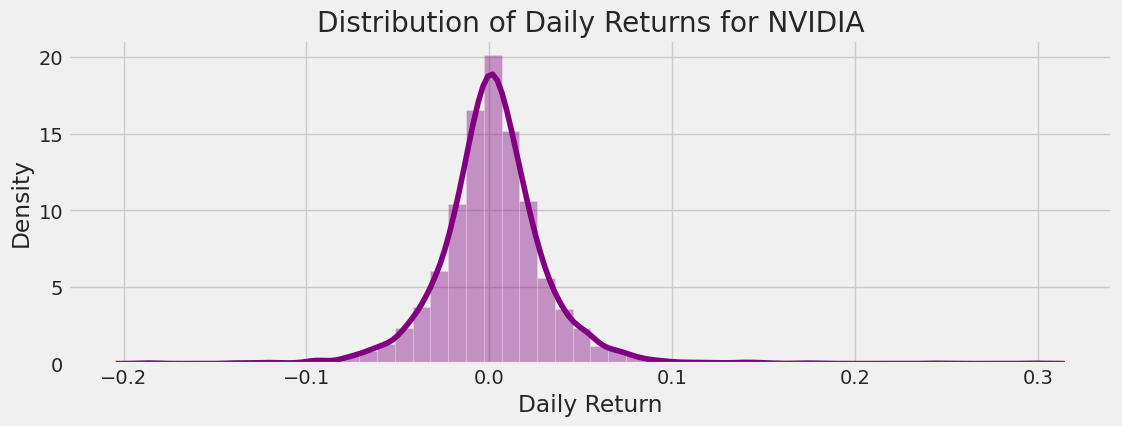

In [8]:
# Creating a figure for plotting the distribution of daily returns
fig, ax = plt.subplots(figsize=(12, 4))  # Set the size of the plot

# Plotting the distribution of daily returns using a histogram and KDE
sns.distplot(company["Daily Return"].dropna(), color="purple", label='Daily Return Distribution', ax=ax)  # Plotting the distribution

# Adding title and labels
ax.set_title(f"Distribution of Daily Returns for {company_title}")  # Title of the plot
ax.set_xlabel('Daily Return')  # Label for X-axis

# Displaying the plot
plt.show()

# Saving the plot using the save_plot function
save_plot(fig, 'NVIDIA_Stock_Daily_Returns_Distribution')  # Save the figure as 'NVIDIA_Stock_Daily_Returns_Distribution.png' with 300 DPI


##**Technical Analysis**
This section enhances the feature engineering process for stock price prediction by calculating various technical indicators and preparing target variables for model training.

In [9]:
# Feature Engineering using Adjusted Close prices
# Replace 'Close' with 'Adj Close' in feature engineering to use adjusted closing prices

# Calculate Relative Strength Index (RSI)
data['RSI'] = ta.rsi(data['Adj Close'], length=15)  # RSI with a window of 15 days

# Calculate Exponential Moving Averages (EMAs) for different lengths
data['EMAF'] = ta.ema(data['Adj Close'], length=20)   # EMA for 20 days
data['EMAM'] = ta.ema(data['Adj Close'], length=100)  # EMA for 100 days
data['EMAS'] = ta.ema(data['Adj Close'], length=150)  # EMA for 150 days

# Calculate the target for prediction (difference between Adjusted Close of next day and Open of current day)
data['Target'] = data['Adj Close'] - data['Open']     # Calculate the difference
data['Target'] = data['Target'].shift(-1)             # Shift by one day to use as prediction target

# Create a binary target class based on whether the stock price increased (1) or not (0)
data['TargetClass'] = [1 if x > 0 else 0 for x in data['Target']]

# Shift the Adjusted Close price to get the next day's closing price
data['TargetNextClose'] = data['Adj Close'].shift(-1)

# Dropping rows with missing values and unnecessary columns
data.dropna(inplace=True)  # Remove rows with NaN values
data.drop(['Volume', 'Close'], axis=1, inplace=True)  # Drop 'Volume' and 'Close' columns

# Select the relevant dataset for model input
data_set = data.iloc[:, 0:11]  # Selecting the first 11 columns

# Display the top 20 rows of the prepared dataset for preview
print(data_set.head(20))


              Open    High     Low  Adj Close        RSI      EMAF      EMAM  \
Date                                                                           
2009-07-21  3.0475  3.0600  2.9225   2.745156  61.968729  2.563906  2.350703   
2009-07-22  2.9325  3.0950  2.9125   2.813957  64.779658  2.587721  2.359877   
2009-07-23  3.0725  3.2600  3.0400   2.981372  70.469962  2.625211  2.372183   
2009-07-24  3.1500  3.2500  3.1300   2.972199  69.807879  2.658258  2.384065   
2009-07-27  3.2100  3.3025  3.1800   2.985959  70.257018  2.689467  2.395984   
2009-07-28  3.2325  3.2950  3.2050   2.990546  70.414220  2.718142  2.407757   
2009-07-29  3.2225  3.2425  3.1625   2.930918  65.586304  2.738406  2.418117   
2009-07-30  3.2500  3.2925  3.1925   2.953852  66.531934  2.758925  2.428725   
2009-07-31  3.2200  3.2775  3.1450   2.965318  67.017429  2.778581  2.439351   
2009-08-03  3.3100  3.3575  3.2475   3.045585  70.253778  2.804010  2.451356   
2009-08-04  3.2625  3.4000  3.2575   3.0

In [10]:
# Summary statistics for the dataset
print(data_set.describe())


              Open         High          Low    Adj Close          RSI  \
count  3624.000000  3624.000000  3624.000000  3624.000000  3624.000000   
mean     69.226207    70.480381    67.919696    68.975568    54.549208   
std     105.066222   106.924321   103.055205   105.087409    12.236211   
min       2.180000     2.262500     2.162500     2.036506    20.024589   
25%       3.972500     4.024375     3.921875     3.706392    45.777392   
50%      16.438750    16.650000    16.246250    16.189399    54.703052   
75%      76.270000    78.353750    75.340626    77.041838    63.316151   
max     502.160004   505.480011   492.220001   504.045685    90.973436   

              EMAF         EMAM         EMAS       Target  TargetClass  \
count  3624.000000  3624.000000  3624.000000  3624.000000  3624.000000   
mean     67.751651    62.978282    60.462901    -0.246110     0.208885   
std     102.740640    93.023927    88.000893     3.202078     0.406568   
min       2.190639     2.350703     2

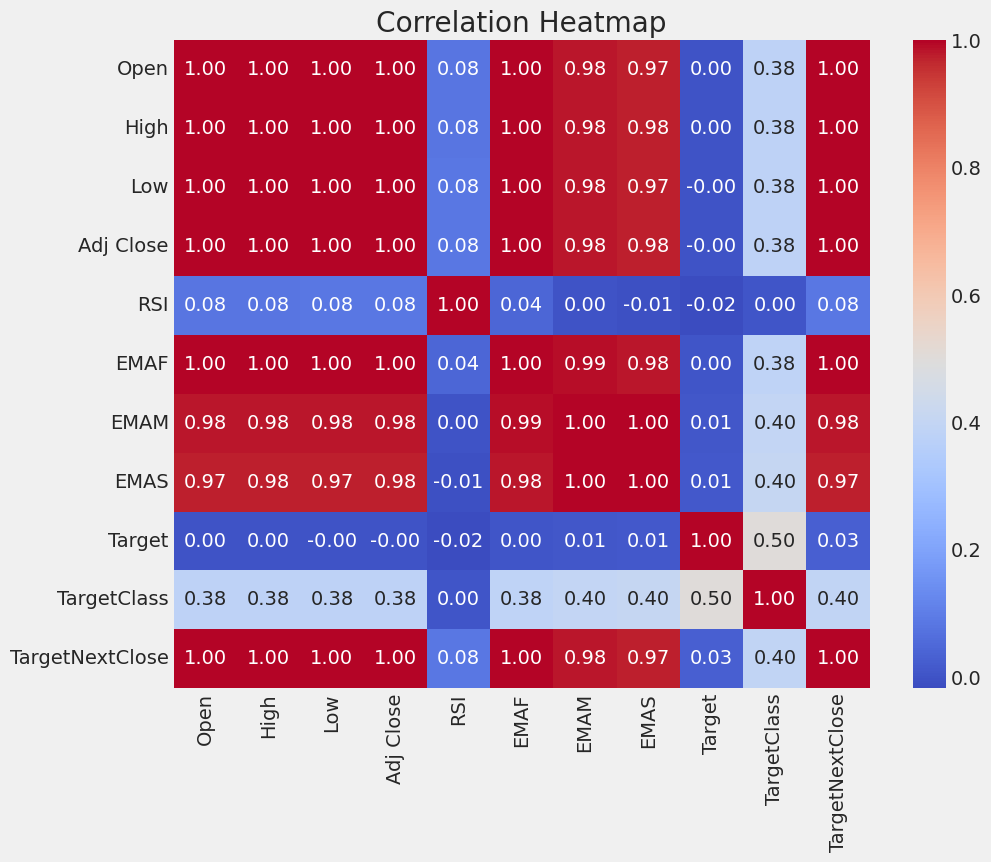

In [11]:
# Creating a figure for plotting the correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8))  # Set the size of the plot

# Generate the correlation matrix and create a heatmap
sns.heatmap(data_set.corr(), annot=True, cmap='coolwarm', fmt='.2f', ax=ax)
# annot=True: Display the correlation coefficients on the heatmap
# cmap='coolwarm': Use the coolwarm color map
# fmt='.2f': Format the correlation coefficients to two decimal places

# Adding title to the heatmap
ax.set_title('Correlation Heatmap')  # Title of the plot

# Displaying the plot
plt.show()

# Saving the plot using the save_plot function
save_plot(fig, 'Correlation_Heatmap')  # Save the figure as 'Correlation_Heatmap.png' with 300 DPI


An analysis of the trends and implications based on the heatmap:

Open, High, Low, Adj Close: These stock market attributes (opening price, highest price, lowest price, and adjusted closing price) are typically highly correlated with each other, as indicated by the 1.00 correlation coefficients. This means that when the opening price of a stock is high on a given day, it is likely that the high, low, and adjusted close are also higher.

RSI (Relative Strength Index): This is a momentum indicator that measures the magnitude of recent price changes to evaluate overbought or oversold conditions. It does not show a strong correlation with the Open, High, Low, and Adj Close prices, which is typical as RSI is intended to provide information that is not provided by prices alone.

EMAF, EMAM, EMAS (Exponential Moving Averages for Fast, Medium, and Slow): These indicators are typically used to smooth out price data and identify trends over time. They show very high correlations with each other and with the Open, High, Low, and Adj Close prices. This is expected since moving averages are directly calculated from the price data.

Target: This variable does not show a strong correlation with the other variables. The 'Target' represents a derived variable, such as the difference between two prices, this lack of correlation might indicate that it does not move in tandem with other market indicators, providing potentially useful independent information for prediction models.

TargetClass: A binary or categorical variable derived from price data, it shows moderate correlation with prices. This is a representation of whether the stock closed higher (1) or lower (0) than it opened, for instance.

TargetNextClose: Shows a perfect correlation with the Open, High, Low, and Adj Close prices. This suggests it is a lagged variable of price, meaning today's 'NextClose' is yesterday's 'Adj Close'.

Overall, the heatmap suggests that the market indicators based on price (Open, High, Low, Adj Close, and the various EMA features) move closely together, which is typical in financial time series. Momentum and derivative indicators like RSI and Target offer less correlated information, which can be valuable in predictive modeling as they may capture aspects of the data that pure price information does not. For trading strategies and model building, it's advantageous to use a combination of both highly correlated and less correlated features to capture different facets of market behavior.

<ipython-input-12-7bfcbf14f1d8>:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_set.hist(ax=ax)


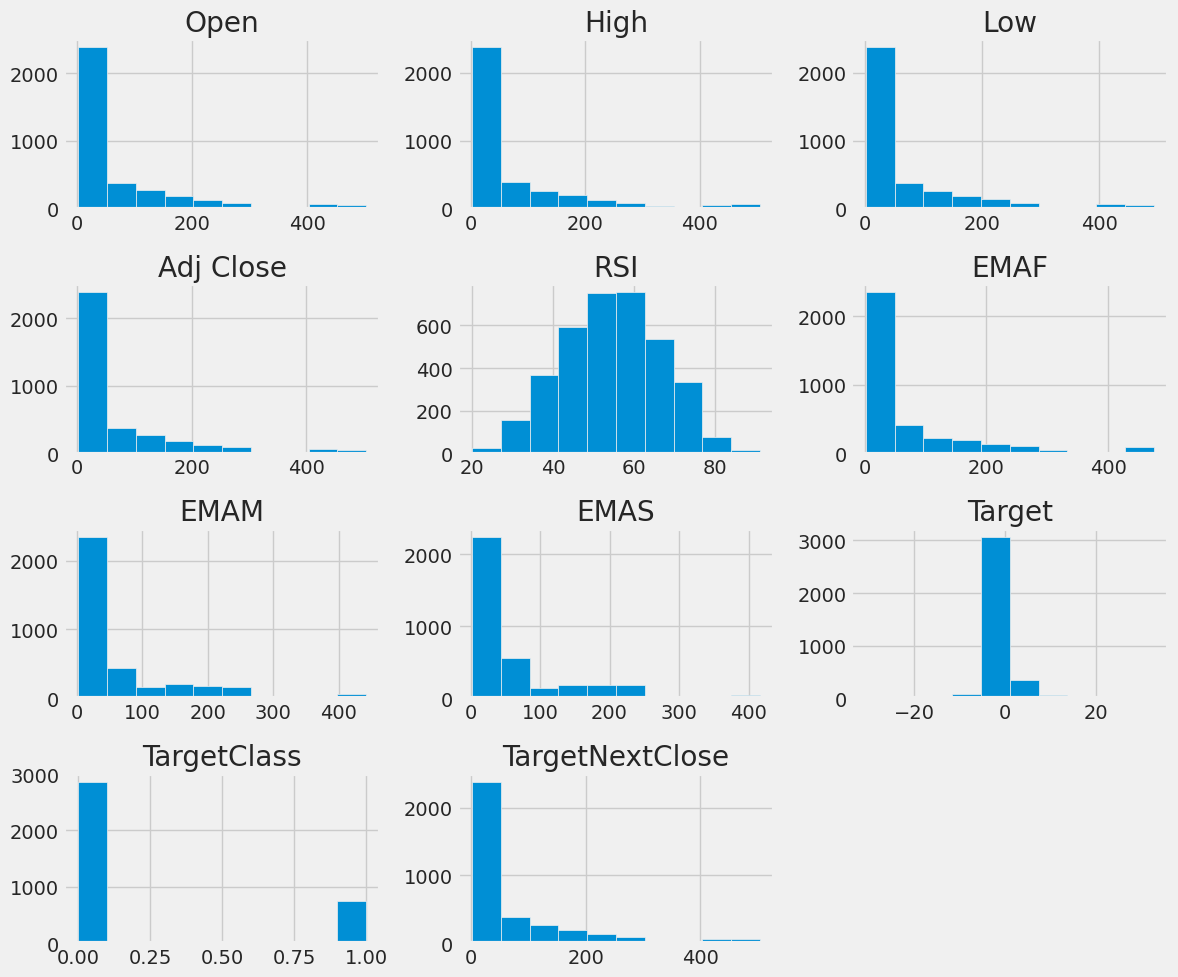

In [12]:
# Creating histograms for each column in the dataset
fig, ax = plt.subplots(figsize=(12, 10))  # Set the size of the figure

# Automatically generate histograms for all columns in the DataFrame
data_set.hist(ax=ax)

# Adjusting layout for better readability
plt.tight_layout()  # Adjusts the plots to fit into the figure area

# Displaying the histograms
plt.show()

# Saving the histograms using the save_plot function
save_plot(fig, 'Feature_Histograms')  # Save the figure as 'Feature_Histograms.png' with 300 DPI


##**Data Preprocessing**
This section scales the features in the dataset to a range between 0 and 1 using MinMaxScaler. It then prepares the input features for the model by considering 'backcandles' number of past observations for each of the first 8 features. The dataset is then split into training and testing sets, with 80% of the data used for training.

In [13]:
# Importing MinMaxScaler for feature scaling
from sklearn.preprocessing import MinMaxScaler

# Scaling the features to a range of 0 to 1
sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(data_set)  # Fit the scaler to the data and transform

# Initializing variables for feature preparation
X = []
backcandles = 70  # Number of past observations to consider

# Preparing the input features for the model
for j in range(8):  # Iterate through the first 8 features
    feature_data = []
    for i in range(backcandles, len(data_set_scaled)):  # Iterate through the data
        feature_data.append(data_set_scaled[i - backcandles:i, j])  # Append the past 'backcandles' observations
    X.append(feature_data)

# Rearranging the array dimensions
X = np.moveaxis(X, [0], [2])  # Move the features to the last axis
X, yi = np.array(X), np.array(data_set_scaled[backcandles:, -1])  # Convert to numpy arrays
y = np.reshape(yi, (len(yi), 1))  # Reshape the target variable

# Splitting the dataset into training and testing sets
split_limit = int(len(X) * 0.8)  # 80% of the data for training
X_train, X_test = X[:split_limit], X[split_limit:]  # Split the features
y_train, y_test = y[:split_limit], y[split_limit:]  # Split the target variable


##**Model Definition**
This section constructs an LSTM model with multiple layers, suitable for time series prediction like stock prices. The plot_model function visualizes the architecture, and nvidia_model.summary() provides a summary of the model, including the number of parameters and layer configurations.

In [14]:
# Define the input shape for the LSTM model
input_shape = (backcandles, 8)  # 'backcandles' time steps and 8 features

# Creating the Sequential model
nvidia_model = Sequential()

# Adding LSTM layers with Dropout for regularization
nvidia_model.add(LSTM(100, return_sequences=True, input_shape=input_shape))  # First LSTM layer with 150 units
nvidia_model.add(Dropout(0.2))  # Dropout to prevent overfitting

nvidia_model.add(LSTM(75, return_sequences=True))  # Second LSTM layer with 100 units
nvidia_model.add(Dropout(0.2))  # Dropout to prevent overfitting

nvidia_model.add(LSTM(50))  # Third LSTM layer with 100 units, return_sequences is False by default
nvidia_model.add(Dropout(0.2))  # Dropout to prevent overfitting

# Adding Dense layers at the end
nvidia_model.add(Dense(25))  # Dense layer with 25 units
nvidia_model.add(Dense(1))   # Output layer with 1 unit for regression output


In [15]:
# nvidia_model = Sequential()
# nvidia_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
# nvidia_model.add(MaxPooling1D(pool_size=2))
# nvidia_model.add(LSTM(50))
# nvidia_model.add(Dropout(0.2))
# nvidia_model.add(Flatten())
# nvidia_model.add(Dense(1))

In [16]:
# nvidia_model = Sequential()
# nvidia_model.add(LSTM(50, return_sequences=True, input_shape=input_shape))
# nvidia_model.add(Dropout(0.2))
# nvidia_model.add(LSTM(100, return_sequences=True))
# nvidia_model.add(Dropout(0.2))
# nvidia_model.add(LSTM(150))
# nvidia_model.add(Dropout(0.2))
# nvidia_model.add(Dense(1))

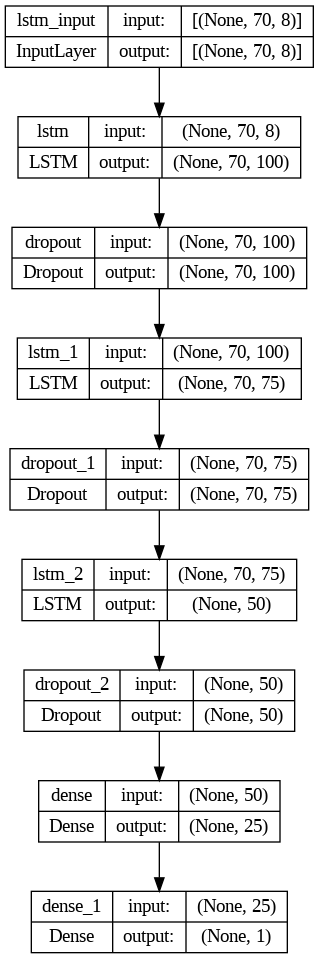

In [17]:
# Visualize the model architecture
tf.keras.utils.plot_model(nvidia_model, show_shapes=True)

In [18]:
# Displaying the model summary
nvidia_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 70, 100)           43600     
                                                                 
 dropout (Dropout)           (None, 70, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 70, 75)            52800     
                                                                 
 dropout_1 (Dropout)         (None, 70, 75)            0         
                                                                 
 lstm_2 (LSTM)               (None, 50)                25200     
                                                                 
 dropout_2 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 25)                1

###Define Custom Learning Rate and Callbacks
This section provides a custom learning rate scheduler that adjusts the learning rate based on the epoch number. It uses linear scaling for the first 150 epochs, exponential decay up to the 400th epoch, and then a constant rate. The plot visualizes these changes over 1000 epochs.

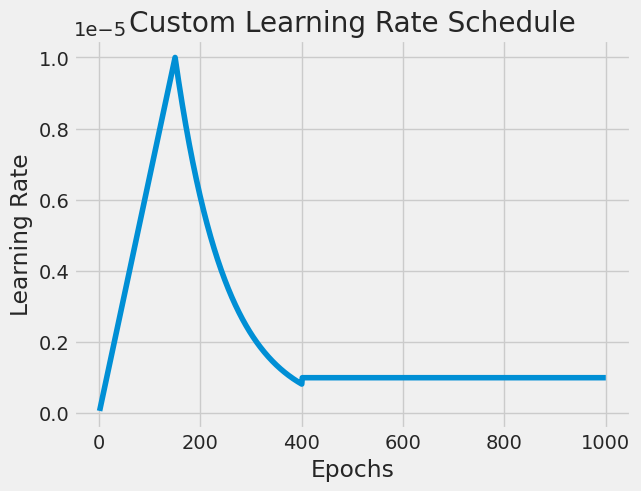

In [19]:
# Define the custom learning rate scheduler function
def scheduler(epoch):
    """
    Custom learning rate scheduler function.

    Parameters:
    epoch (int): The current training epoch

    Returns:
    float: The learning rate for the given epoch
    """
    if epoch <= 150:
        # Linear increase in learning rate for the first 150 epochs
        lrate = (10 ** -5) * (epoch / 150)
    elif epoch <= 400:
        # Exponential decay in learning rate from epochs 151 to 400
        initial_lrate = (10 ** -5)
        k = 0.01
        lrate = initial_lrate * math.exp(-k * (epoch - 150))
    else:
        # Constant learning rate after 400 epochs
        lrate = (10 ** -6)
    return lrate

# Visualizing the learning rate schedule
epochs = range(1, 1001)  # Epochs from 1 to 1000
lrate = [scheduler(epoch) for epoch in epochs]  # Learning rates for each epoch

# Plotting the learning rate schedule
plt.plot(epochs, lrate)
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Custom Learning Rate Schedule')
plt.show()


###Defining Callbacks
This code creates two callbacks for use in a TensorFlow/Keras model training process:

Learning Rate Scheduler Callback (callback_lr): To adjust the learning rate dynamically during the training process.

Early Stopping Callback (early_stopping): To prevent overfitting by stopping the training process if the validation loss does not improve.

In [20]:
# Create a callback for the learning rate scheduler
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Define EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


##**Compilation and Training**
The model is trained on the NVIDIA stock data (X_train, y_train) and validated on 30% of the training data. The callbacks are used to optimize the learning process.

In [21]:
# Compile your model using the specified optimizer, loss, and metrics
nvidia_model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mse', metrics=tf.keras.metrics.RootMeanSquaredError())

# Fit your model using the compiled settings, custom learning rate scheduler, and training data
nvidia_history = nvidia_model.fit(X_train, y_train, epochs=1000, batch_size=16, shuffle=True, validation_split = 0.25, callbacks=[callback_lr, early_stopping])

Epoch 1/1000
134/134 [==============================] - 24s 36ms/step - loss: 0.0033 - root_mean_squared_error: 0.0575 - val_loss: 0.0306 - val_root_mean_squared_error: 0.1748 - lr: 0.0000e+00
Epoch 2/1000
134/134 [==============================] - 2s 14ms/step - loss: 0.0031 - root_mean_squared_error: 0.0561 - val_loss: 0.0301 - val_root_mean_squared_error: 0.1736 - lr: 6.6667e-08
Epoch 3/1000
134/134 [==============================] - 3s 21ms/step - loss: 0.0031 - root_mean_squared_error: 0.0554 - val_loss: 0.0293 - val_root_mean_squared_error: 0.1713 - lr: 1.3333e-07
Epoch 4/1000
134/134 [==============================] - 2s 15ms/step - loss: 0.0028 - root_mean_squared_error: 0.0525 - val_loss: 0.0282 - val_root_mean_squared_error: 0.1679 - lr: 2.0000e-07
Epoch 5/1000
134/134 [==============================] - 2s 14ms/step - loss: 0.0025 - root_mean_squared_error: 0.0497 - val_loss: 0.0268 - val_root_mean_squared_error: 0.1637 - lr: 2.6667e-07
Epoch 6/1000
134/134 [=================

###Plotting Training and Validation losses
This code snippet is designed to access the training history data from the nvidia_history object, which contains information about the loss and root mean squared error (RMSE) for both training and validation datasets over each epoch. The epochs range is created for use in potential plots of these metrics.

In [22]:
# Accessing the training history from the nvidia_history object
history_dict = nvidia_history.history

# Extracting training and validation metrics
loss = history_dict["loss"]  # Training loss for each epoch
root_mean_squared_error = history_dict["root_mean_squared_error"]  # Training Root Mean Squared Error for each epoch
val_loss = history_dict["val_loss"]  # Validation loss for each epoch
val_root_mean_squared_error = history_dict["val_root_mean_squared_error"]  # Validation Root Mean Squared Error for each epoch

# Creating a range of epochs for plotting
epochs = range(1, len(loss) + 1)  # Epochs from 1 to the number of epochs trained


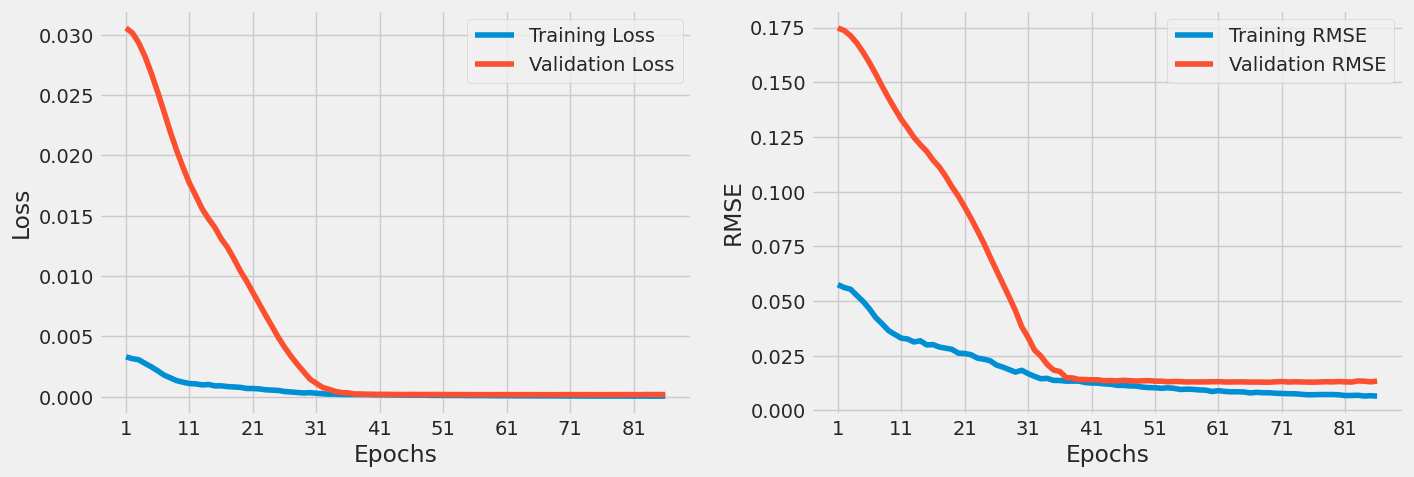

In [23]:
# Plotting the training and validation metrics in two subplots
fig, (ax1, ax2) = plt.subplots(1, 2)

# Setting the dimensions of the overall figure
fig.set_figheight(5)
fig.set_figwidth(15)

# Plotting training and validation loss
ax1.plot(epochs, loss, label='Training Loss')  # Training loss per epoch
ax1.plot(epochs, val_loss, label='Validation Loss')  # Validation loss per epoch
ax1.set(xlabel="Epochs", ylabel="Loss")  # Setting x and y labels
ax1.legend()  # Adding the legend
ax1.set_xticks(range(1, len(loss) + 1, 10))  # Setting x-axis ticks at intervals of 10 epochs

# Plotting training and validation RMSE
ax2.plot(epochs, root_mean_squared_error, label="Training RMSE")  # Training RMSE per epoch
ax2.plot(epochs, val_root_mean_squared_error, label="Validation RMSE")  # Validation RMSE per epoch
ax2.set(xlabel="Epochs", ylabel="RMSE")  # Setting x and y labels
ax2.legend()  # Adding the legend
ax2.set_xticks(range(1, len(loss) + 1, 10))  # Setting x-axis ticks at intervals of 10 epochs

# Displaying the plots
plt.show()

# Saving the figure with a specified filename and resolution
save_plot(fig, 'Training_Validation_Metrics')  # Save the figure as 'Training_Validation_Metrics.png' with 300 DPI


##**Model Prediction**
This code uses the trained nvidia_model to make predictions on the test data (X_test). It then applies a MinMaxScaler to invert the scaled predictions and the actual prices (both training and test sets) back to their original scale. This allows for a direct comparison between the model's predictions and the actual stock prices.

In [24]:
# Predicting on the test data using the trained nvidia_model
nvidia_predictions = nvidia_model.predict(X_test)  # Model predictions on the test dataset

# Creating a new MinMaxScaler instance for inverting predictions
sc_test = MinMaxScaler(feature_range=(0,1))

# Fitting the scaler on the last column of the dataset and transforming it
# This step ensures that we have the correct scaling parameters for inversion
test_scaled = sc_test.fit_transform(data_set.iloc[:, -1].values.reshape(-1, 1))

# Inverting the predictions to the original scale
nvidia_predictions = sc_test.inverse_transform(nvidia_predictions)

# Inverting the actual test and training prices to the original scale
actual_prices_test = sc_test.inverse_transform(y_test)  # Actual test prices
actual_prices_train = sc_test.inverse_transform(y_train)  # Actual training prices


23/23 [==============================] - 1s 7ms/step


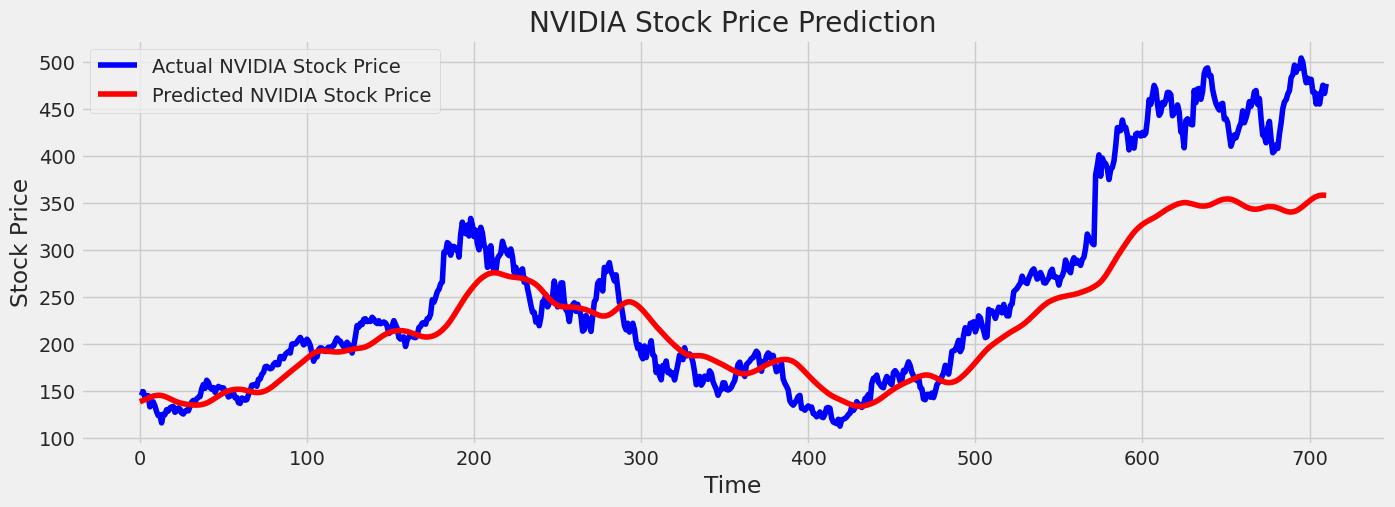

In [25]:
# Plotting the actual and predicted NVIDIA stock prices
fig, ax = plt.subplots(figsize=(15, 5))  # Set the size of the plot

# Plotting the actual stock prices
ax.plot(actual_prices_test, color='blue', label='Actual NVIDIA Stock Price')  # Actual prices in blue

# Plotting the predicted stock prices
ax.plot(nvidia_predictions, color='red', label='Predicted NVIDIA Stock Price')  # Predictions in red

# Adding title, labels, and legend
ax.set_title('NVIDIA Stock Price Prediction')  # Title of the plot
ax.set_xlabel('Time')  # Label for the X-axis
ax.set_ylabel('Stock Price')  # Label for the Y-axis
ax.legend()  # Adding a legend to distinguish actual and predicted prices

# Displaying the plot
plt.show()

# Saving the plot using the save_plot function
save_plot(fig, 'NVIDIA_Stock_Price_Actual_vs_Predicted')  # Save the figure as 'NVIDIA_Stock_Price_Actual_vs_Predicted.png' with 300 DPI


##**Model Evaluation**
This code calculates two important metrics for evaluating the performance of the model: RMSE and MAPE. RMSE provides a measure of the differences between predicted and actual values, while MAPE gives an indication of prediction accuracy in percentage terms.

In [26]:
# Calculating the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mean_squared_error(actual_prices_test, nvidia_predictions))  # RMSE computation
print(f'Root Mean Squared Error (RMSE): {rmse}')  # Print RMSE

# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the mean absolute percentage error between true and predicted values.

    Parameters:
    y_true (array-like): True values
    y_pred (array-like): Predicted values

    Returns:
    float: MAPE
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)  # Convert to numpy arrays for calculation
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Calculate and return MAPE

# Calculating MAPE
mape = mean_absolute_percentage_error(actual_prices_test, nvidia_predictions)  # MAPE computation
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')  # Print MAPE


Root Mean Squared Error (RMSE): 54.74655583928467
Mean Absolute Percentage Error (MAPE): 13.40%


The provided Root Mean Squared Error (RMSE) and Mean Absolute Percentage Error (MAPE) are metrics used to quantify the model's prediction errors:

Root Mean Squared Error (RMSE) - 54.74:

RMSE measures the square root of the average of the squares of the errors. The error is the difference between the predicted values and the actual values. An RMSE of 54.74 means that the model's predictions are, on average, approximately 54.74 units away from the actual stock prices in the test set. In the context of stock prices, if the price scale is in the hundreds of dollars, an RMSE of this magnitude indicates a reasonably good fit of the model to the data, although there is still noticeable room for improvement, especially if we consider that investors prefer more precise predictions for their decision-making.

Mean Absolute Percentage Error (MAPE) - 13.40%:

MAPE expresses the average absolute percent error between the predicted values and the actual values. A MAPE of 13.40% suggests that the model's predictions are, on average, 13.40% different from the actual values. This level of error implies that the model has a moderate predictive accuracy.

These error metrics are useful for model evaluation and comparison. They provide a sense of the model's accuracy in predicting new data and can highlight areas where model performance might need to be improved. Given the complexity and volatility of stock price movements, achieving low error rates can be challenging, but it is essential for the model to be practically useful in a trading context.

This code creates a comprehensive plot showing the NVIDIA stock's training, testing, and predicted prices over time, facilitating a visual comparison of the model's performance against actual data.

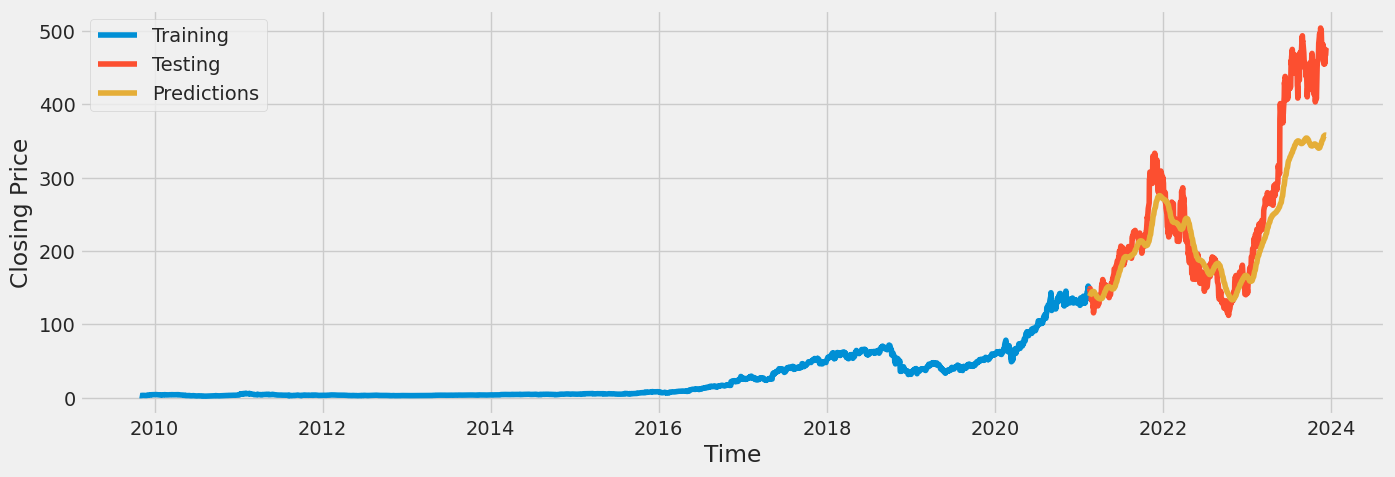

In [27]:
# Plotting training, testing, and predictions for NVIDIA stock prices
fig, ax = plt.subplots(figsize=(15, 5))  # Set the size of the plot

# Plotting the training prices
ax.plot(data_set.index[backcandles: len(actual_prices_train) + backcandles],
         actual_prices_train.reshape(-1), label='Training')  # Training data plot

# Plotting the testing prices
ax.plot(data_set.index[len(actual_prices_train) + backcandles:],
         actual_prices_test.reshape(-1), label='Testing')  # Testing data plot

# Plotting the predicted prices
ax.plot(data_set.index[len(actual_prices_train) + backcandles:],
         nvidia_predictions.reshape(-1), label='Predictions')  # Predictions plot

# Adding labels and legend
ax.set_xlabel('Time')  # X-axis label
ax.set_ylabel('Closing Price')  # Y-axis label
ax.legend(loc='best')  # Legend with the best location

# Displaying the plot
plt.show()

# Saving the plot using the save_plot function
save_plot(fig, 'NVIDIA_Stock_Price_Prediction')  # Save the figure as 'NVIDIA_Stock_Price_Comparison.png' with 300 DPI


##**Conclusion**

The graph shows three distinct lines representing the training data, testing data, and the model's predictions for NVIDIA's stock prices:

Training Data (Blue Line):

This portion of the graph represents the historical closing prices of NVIDIA stock used to train the machine learning model. The stable and gradual increase from the left side of the graph up to the point where the blue line ends suggests a period of growth in NVIDIA's stock value over time.

Testing Data (Red Line):

The red line indicates the actual closing prices of NVIDIA stock that were not used for training (i.e., they were held back for testing purposes). This data tests the model's predictive capabilities on unseen data. The testing data shows a volatile period with significant upward and downward movements, indicating a more challenging market phase for the model to predict.

Predictions (Yellow Line):

The predictions made by the model are plotted with the yellow line. This is the model's attempt to forecast the stock prices, and it is overlaid on the testing data to show how well the model's predictions align with the actual stock prices.

When comparing the red and yellow lines, you can assess the model's performance. A closer overlap indicates a higher accuracy of the predictions. From the visible part of the graph, it appears that the model has captured the overall trend of the stock prices during the testing phase reasonably well, as the yellow line follows the general direction of the red line. However, the model seems to smooth out some of the volatility, not capturing some of the more dramatic peaks and troughs that the actual stock price experienced.

This code saves the nvidia_model to a file named 'nvidia_model.h5' using the HDF5 format.

In [28]:
# Save the NVIDIA model
model_filename = 'nvidia_model.h5'  # Define the filename for the saved model
nvidia_model.save(model_filename)  # Save the model in HDF5 file format

print(f"Model saved as {model_filename}")


Model saved as nvidia_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
